# Vizualize Crime Data

This notebook is a exploration of crime data in Seattle performed for assignment on of the Coursera "Communicating Data Science Results" class. I will explore criminal activity in Seattle over time by week to see which weeks are the worst for crime in terms of total crime and type of crime. Additionally, I expect that crime varies by the day of week. 

My hypothesis is that the type of crimes committed changes over time. Additionally certain crime types are most likely to happen on specific days of the week.

## Read Provided Data

### load data from CSV
Let's load all of the provided data for Seattle.


In [129]:
types <- list (seattle = c("character","character",                # 'RMS.CDW.ID' 'General.Offense.Number'
                           "character","character","character","character", # 'Offense.Code' 'Offense.Code.Extension' 'Offense.Type' 'Summary.Offense.Code'
                           "character",                            # 'Summarized.Offense.Description'
                           "character","character","character",    # 'Date.Reported' 'Occurred.Date.or.Date.Range.Start' 'Occurred.Date.Range.End'
                           "character","character",                   # 'Hundred.Block.Location' 'District.Sector'
                           "character","character",                      # 'Zone.Beat' 'Census.Tract.2000' 
                           "numeric","numeric","character",        # 'Longitude' 'Latitude' 'Location' 
                           "numeric","numeric"),                   # 'Month' 'Year'
               sf = c(""))
data <- list()
data$seattle <- read.csv("seattle_incidents_summer_2014.csv",colClasses=types$seattle)
#data$sf <- read.csv("sanfrancisco_incidents_summer_2014.csv")


### clean up data
Many of the fields have non-primitive data types. We need to handle this.
Dates are presented in an in an American standard format which is not recognized by R.

In [130]:
seattle <- data$seattle

readdate <- function(s){ strptime(s,"%m/%d/%Y %I:%M:%S %p") }

n <-names(seattle)
ns <- grepl("Date",n)
dn <- n[ns]

for ( i in dn ){
   seattle[[i]]  <- as.POSIXct(readdate(seattle[[i]]))
}
names(seattle)

[1] "RMS.CDW.ID"                        "General.Offense.Number"           
 [3] "Offense.Code"                      "Offense.Code.Extension"           
 [5] "Offense.Type"                      "Summary.Offense.Code"             
 [7] "Summarized.Offense.Description"    "Date.Reported"                    
 [9] "Occurred.Date.or.Date.Range.Start" "Occurred.Date.Range.End"          
[11] "Hundred.Block.Location"            "District.Sector"                  
[13] "Zone.Beat"                         "Census.Tract.2000"                
[15] "Longitude"                         "Latitude"                         
[17] "Location"                          "Month"                            
[19] "Year"

### load useful libraries

In [131]:
library(lattice,quietly=TRUE)
library(plyr, quietly=TRUE)
library(lubridate,quietly = TRUE)
library(reshape, quietly=TRUE)
library(ggplot2, quietly=TRUE)

## initial exploration

The first step is to explore the data over time. The data is already catagorized by month and year.

In [132]:
table(seattle[,c("Month","Year")])

     Year
Month  2014
    6 11125
    7 11154
    8 10500

We were only given three months worth of data. The crime rate ssems relatively constant over time. However, I'd rather look at the data on a weekly basis.

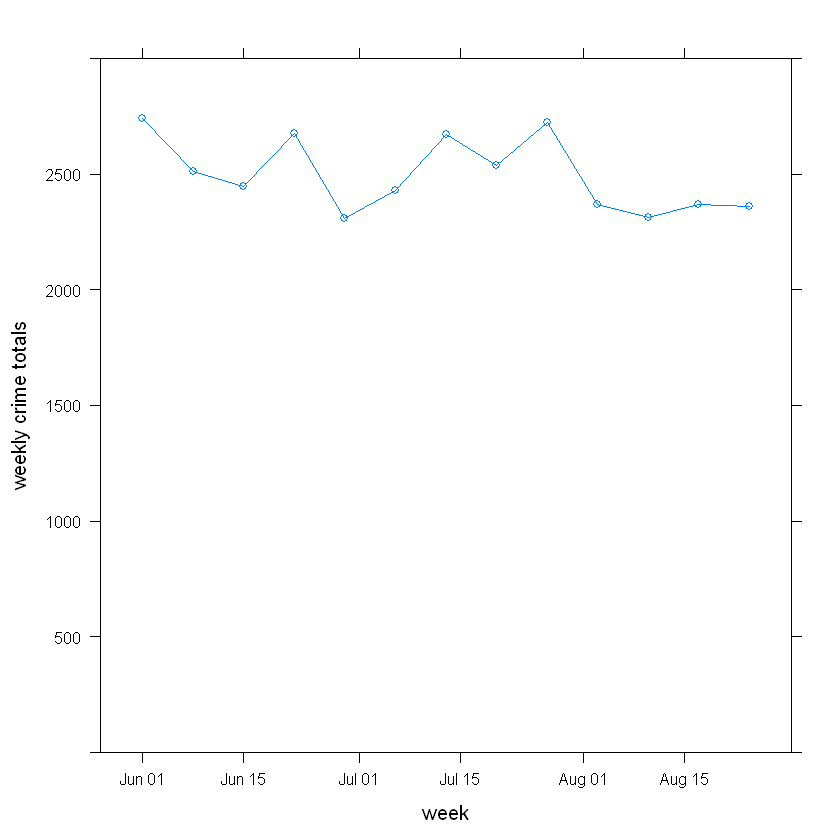

In [133]:
seattle$week <- floor_date(seattle$Occurred.Date.or.Date.Range.Start,unit="week")
wcounts <- ddply(seattle,.(week), function(df){ data.frame(wcount=nrow(df)) })
wcounts <- transform(wcounts, wf=factor(week,as.character(sort(week))) )
wcounts <- subset(wcounts, week < as.POSIXct("2014-08-31"))

#qplot(y=wcount,x=wf,data=wcounts)
#ggplot(wcounts, aes(x=wf, y=wcount) + geom_bar(stat="identity") )

xyplot(wcount~week,wcounts,type=c("l","p"),ylim=c(0,3000),ylab="weekly crime totals")
#barplot(wcount~wf,wcounts)

The crime rate is relatively constant over time. Weeks in June and July do seem to have slightly higher crime rates than the weeks in August. The lower total in August was not due to missing weeks.

## Major Offenses Over Time

The second question is "do the types of crimes change over time?" While the overall crime rate is consistent over the weeks. Do the major types of crimes change on a week to week basis?

To do this I will assign plot the top crime categories over time.

In [134]:
sw <- transform(seattle, week=as.POSIXct(floor_date(Occurred.Date.or.Date.Range.Start,unit="week")))
sw <- subset(sw, week < as.POSIXct("2014-08-31"))

In [135]:
sw.weekly <- ddply(sw,.(week,Summary.Offense.Code),function(df){ data.frame(count=nrow(df))})

Figure out which are the most common crime types.

In [136]:
types <- sort(unique(sw$Summary.Offense.Code))

# count by category
avgbytype <- sapply(types, function(t){
    n <- subset(sw.weekly,Summary.Offense.Code==t)
    mean(n$count)
})
names(avgbytype)<-types
avgbytype <- sort(avgbytype, decreasing = TRUE)

# get those with more than 100 weekly crimes, excluding X
sel <- names(avgbytype[avgbytype > 100])
sel <- sel[sel != 'X']
sel

[1] "2300" "2200" "2400" "1300" "2900" "2600"

By inspecting the table we can give names to the most common crimes and we can assign generic names to them.

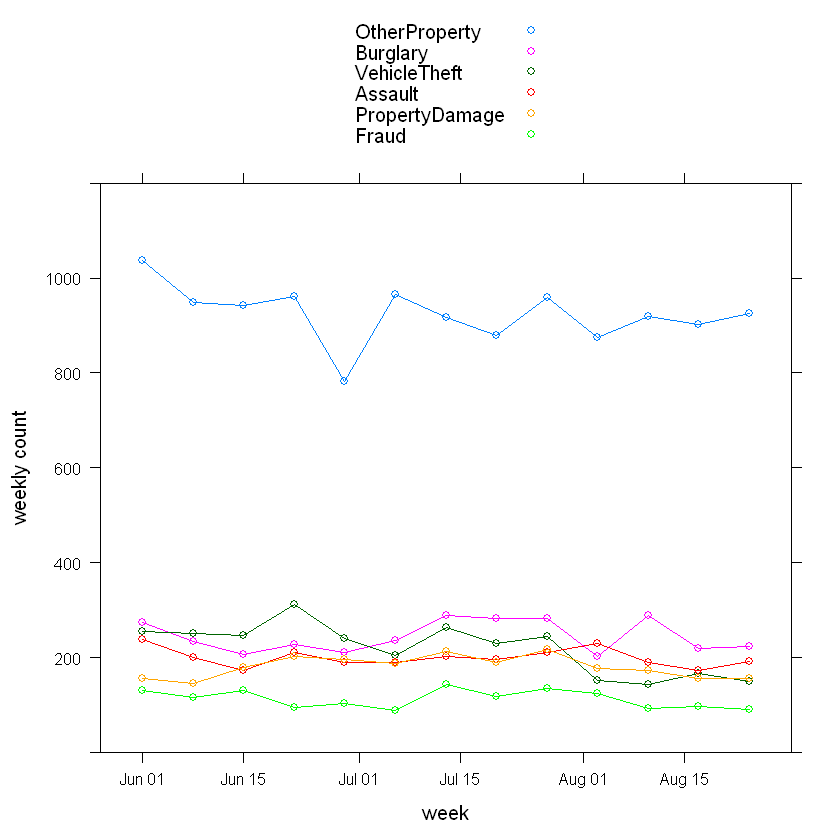

In [137]:
topcrimes <- subset(sw.weekly, Summary.Offense.Code %in% sel)

# fix up factor to have only correct levels in correct order
#topcrimes$Summary.Offense.Code <- droplevels(topcrimes$Summary.Offense.Code)
topcrimes$Summary.Offense.Code <- factor(topcrimes$Summary.Offense.Code, levels = sel)
topcrimes$Summary.Offense.Code <- revalue(topcrimes$Summary.Offense.Code, 
                                          c("1300"="Assault", "2200"="Burglary",
                                            "2300"="OtherProperty", "2400"="VehicleTheft",
                                            "2600"="Fraud", "2900"="PropertyDamage"))
#
xyplot(count~week,topcrimes,type=c("l","p"),group=Summary.Offense.Code,auto.key=TRUE, ylab="weekly count", ylim=c(0,1200))

The major crime types of assault, property crimes and fraud are all relatively stable. Vehical theft and burglary alternate between beeing second and third most common crime. However, **the crime types do not significantly change over time.**

We can futhre show how stable the various crime rates are with a box plot. The average number of each crime are indicated by the black circle. The standard deviation is indicated by the box with the whiskers indicating three times the standard deviation. The colors of the boxes match the line colors above

In [138]:
mycols <- c('blue','magenta','darkgreen', 'red', 'orange','green')

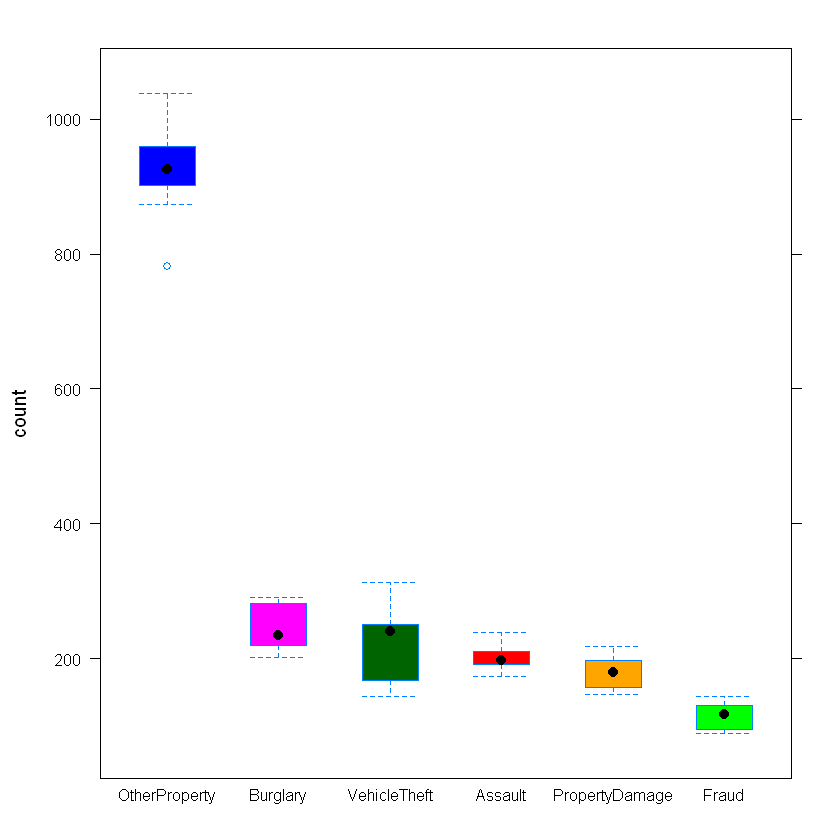

In [139]:
#stripplot(count~Summary.Offense.Code,topcrimes, jitter=.3)
bwplot(count~Summary.Offense.Code,topcrimes, jitter=.3, 
       par.settings = list(box.rectangle = list(fill= rep(mycols,2))) )

I conclude that the **type of crime is relatively steady over time** with the number of vehicle thefts changing the most week to week.

## Impact of day of week on crime type

Here I look at how the type of crime is dependent on the day of the week. I will plot the data based on the day of the week on which the crime occurs.

In [140]:
s2 <- sw
s2 <- mutate(s2, wday = wday(Occurred.Date.or.Date.Range.Start, label=T,abbr=T))

### Day of week only

In [141]:
sdow <- ddply(s2, .(wday), function(df){ data.frame(dcount = nrow(df))})
#barchart(dcount~wday, sdow,ylim=c(0,5500))


In [142]:
sm <- subset(s2, Summary.Offense.Code %in% sel)
scdow <- ddply(sm, .(wday, Summary.Offense.Code), function(df){ data.frame(dcount = nrow(df))})

scdow$Summary.Offense.Code <- factor(scdow$Summary.Offense.Code, levels = sel)
scdow$Summary.Offense.Code <- revalue(scdow$Summary.Offense.Code, 
                                          c("1300"="Assault", "2200"="Burglary",
                                            "2300"="OtherProperty", "2400"="VehicleTheft",
                                            "2600"="Fraud", "2900"="PropertyDamage"))

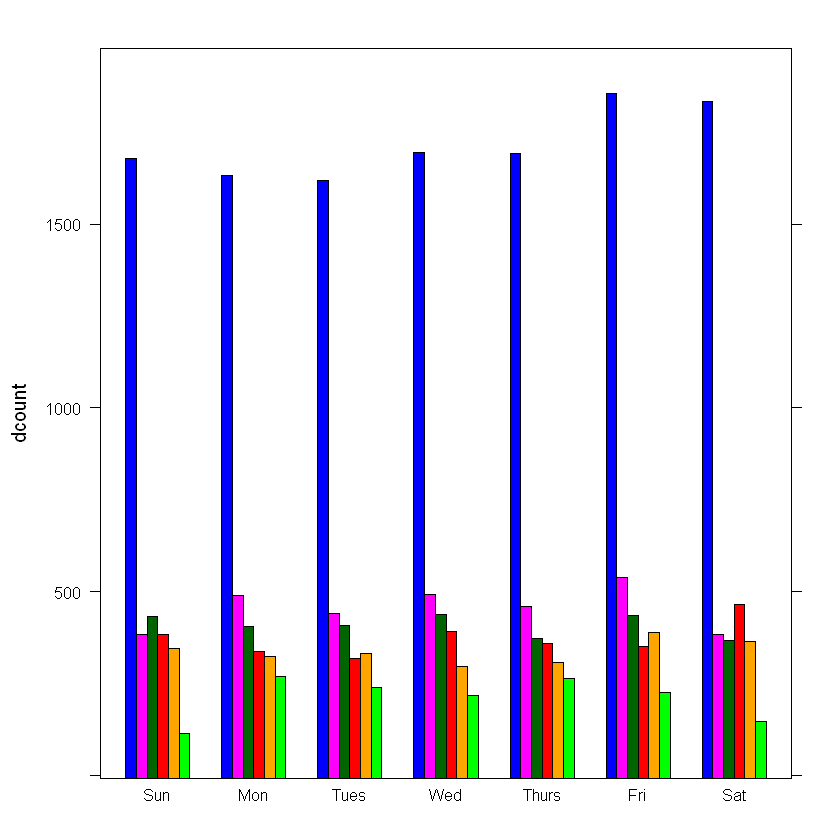

In [143]:
barchart(dcount~wday,scdow, group=Summary.Offense.Code, col=mycols)
#xyplot(dcount~wday,scdow, group=Summary.Offense.Code, col=c('blue','magenta','darkgreen', 'red', 'orange','green'),type=c("l","p"))

The mix of crime on each day of the week changes. The colors are the same as in the previous plots. Most notably, assauts (red) are more predominant on Saturday as might be expected.

In [144]:
scdowot <- ddply(sm, .(wday, Summary.Offense.Code,week), function(df){ data.frame(dcount = nrow(df))})

scdowot$Summary.Offense.Code <- factor(scdowot$Summary.Offense.Code, levels = sel)
scdowot$Summary.Offense.Code <- revalue(scdowot$Summary.Offense.Code, 
                                          c("1300"="Assault", "2200"="Burglary",
                                            "2300"="OtherProperty", "2400"="VehicleTheft",
                                            "2600"="Fraud", "2900"="PropertyDamage"))


### crime by day of week considering weekly variance

Again using a box and whisker plot we can look boht at the weekly trend in crime as well as how consistent that trend is between weeks. The black dots below show the average number of each crimes on a specific day of the week. The boxes and whiskers show how much the crime on that day is changing day to day.

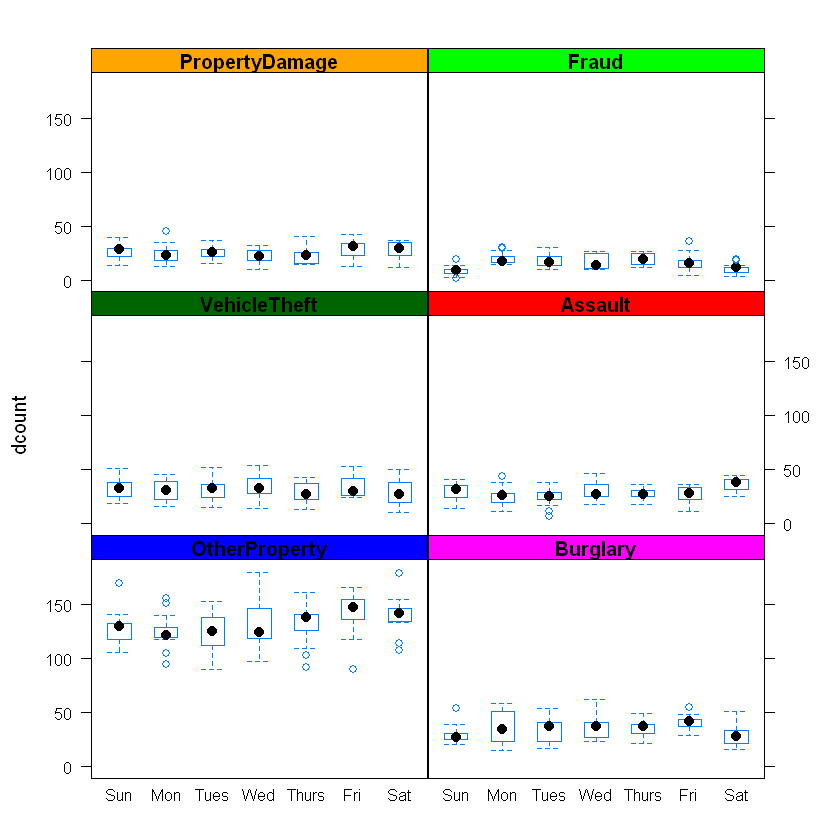

In [145]:
bgColors <- mycols

# Create a function to be passed to "strip=" argument of xyplot
myStripStyle <- function(which.panel, factor.levels, ...) {
    panel.rect(0, 0, 1, 1,
               col = bgColors[which.panel],
               border = 1)
    panel.text(x = 0.5, y = 0.5,
               font=2,
               lab = factor.levels[which.panel],
               col = "black")
}    

bwplot(dcount~wday|Summary.Offense.Code,scdowot, group=week, strip=myStripStyle, layout=c(2,3))
       #par.settings = list(strip.background=list(col=mycols[which.panel]), layout=c(2,3))

The plots show that property crimes are more likely to occure on the Friday and Saturday. Week to week there is a large variance in how many property crimes occur on Wednesday. Assaults consistently occur more often on Saturday. Burglaries are more likely to happen during the week.

## Conclusion

There is some variance in the amount of crimes and the specific types of crime week to week. Additionally some crimes are indeed slightly more likely to happen on a specific day of the week. Certain types of crimes do happen more on specific days of the week.